<a href="https://colab.research.google.com/github/MLDreamer/AIMathematicallyexplained/blob/main/Direct_Preference_Optimization_(DPO)_Mathematical_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PART 1: Bradley-Terry Model - The Foundation

Response A reward: 5.0
Response B reward: 2.0

P(A > B) = 0.953
P(B > A) = 0.047
Sum = 1.000

✓ Visualization saved: dpo_bradley_terry.png


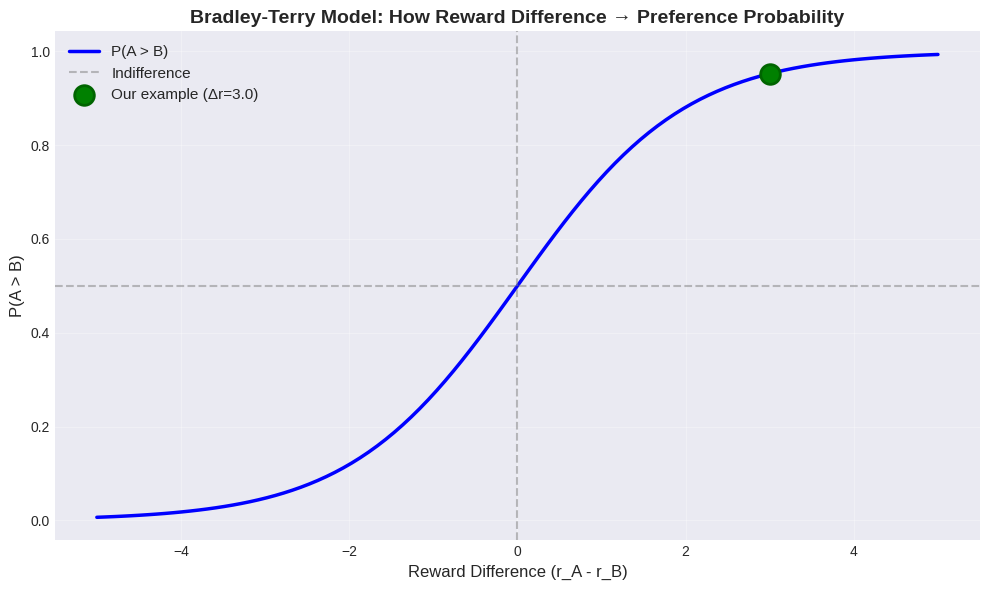


PART 2: The Key Transformation - Reward to Policy Ratio

Reference model probabilities:
  π_ref(good response) = 0.01
  π_ref(bad response) = 0.05

Current policy probabilities:
  π_θ(good response) = 0.04
  π_θ(bad response) = 0.03

Implicit rewards (β=0.1):
  r(good) = 0.139
  r(bad) = -0.051
  Δr = 0.190

P(prefer good over bad) = 0.547

PART 3: DPO Loss Function Mechanics

DPO Loss Breakdown:
  log(π_θ(good) / π_ref(good)) = 1.386
  log(π_θ(bad) / π_ref(bad)) = -0.511
  β * (ratio_good - ratio_bad) = 0.190
  σ(logit) = 0.547
  Loss = -log(σ(logit)) = 0.603

Interpretation:
  ✓ Policy prefers good over bad (logit > 0)
  → Loss is low (0.603), gradient will be small

PART 4: Simulating DPO Training Dynamics

Training Summary:
  Initial P(prefer good) = 0.672
  Final P(prefer good) = 0.691
  Initial π_θ(good) = 0.2600
  Final π_θ(good) = 0.6179
  Initial π_θ(bad) = 0.0010
  Final π_θ(bad) = 0.0010

✓ Visualization saved: dpo_training_dynamics.png


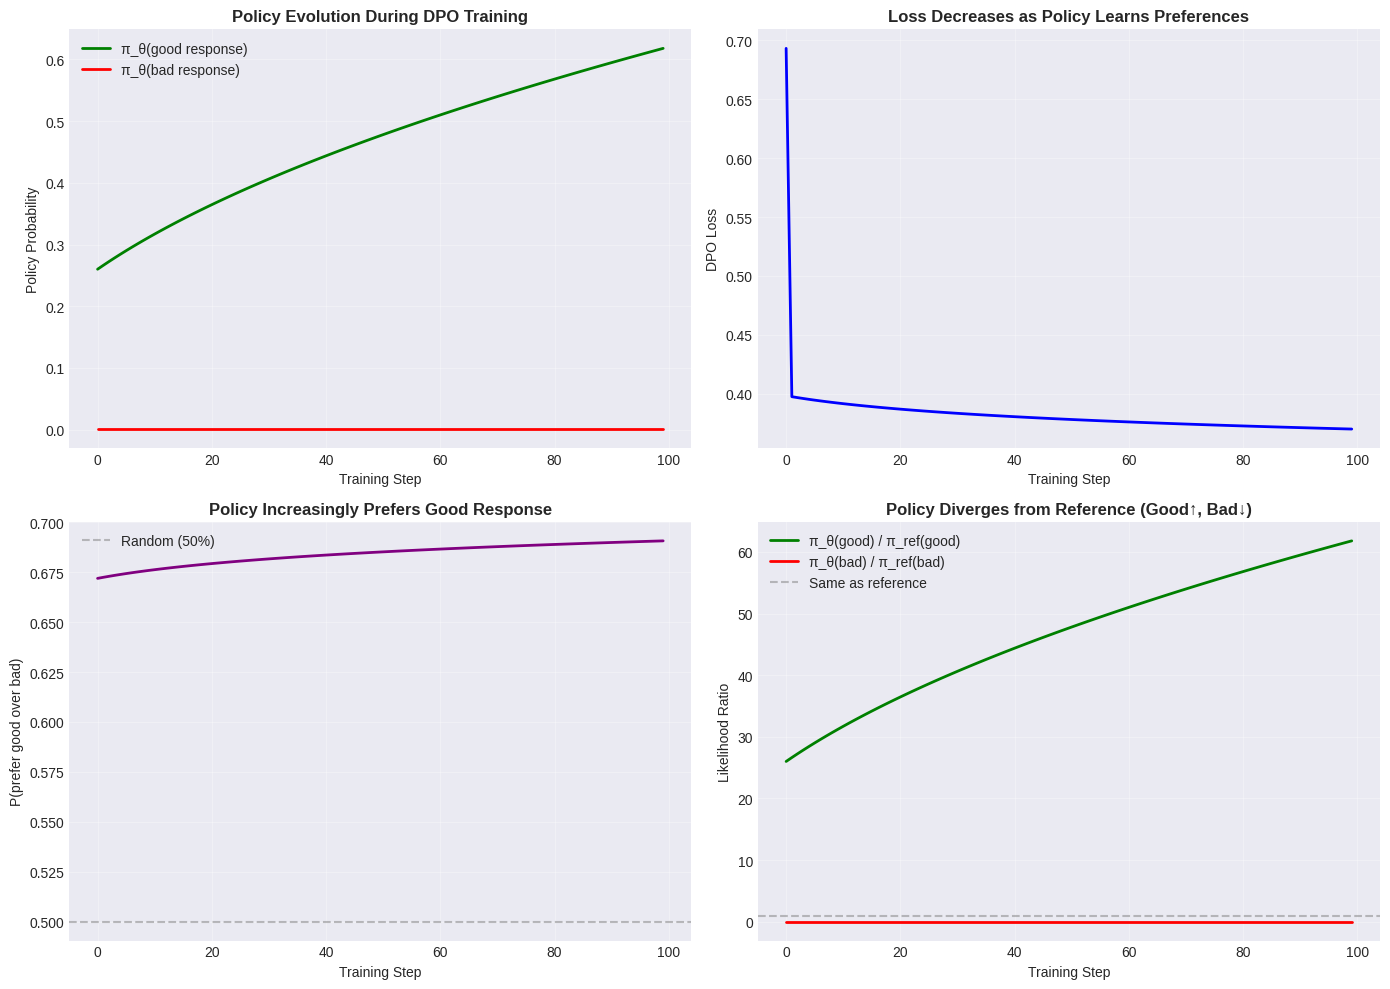


PART 5: RLHF vs DPO Complexity Comparison

┌─────────────────────────┬──────────────────────────┬─────────────────────────┐
│ Aspect                  │ RLHF (PPO)               │ DPO                     │
├─────────────────────────┼──────────────────────────┼─────────────────────────┤
│ Number of Models        │ 3 (Policy, Value, Reward) │ 1 (Policy only)         │
│ Training Stages         │ 2 (RM training + RL)     │ 1 (Direct optimization) │
│ Loss Function           │ Complex (PPO objective)  │ Simple (log-likelihood) │
│ Stability               │ Unstable (mode collapse) │ Stable (supervised learning) │
│ Hyperparameters         │ Many (LR×3, clip, KL, ...) │ Few (LR, β)             │
│ Computational Cost      │ High (sampling + scoring) │ Low (standard gradient) │
│ Distribution Shift      │ Problematic (RM vs Policy) │ Implicitly handled      │
│ Exploration             │ Yes (via sampling)       │ Limited (dataset only)  │
└─────────────────────────┴──────────────────────────┴

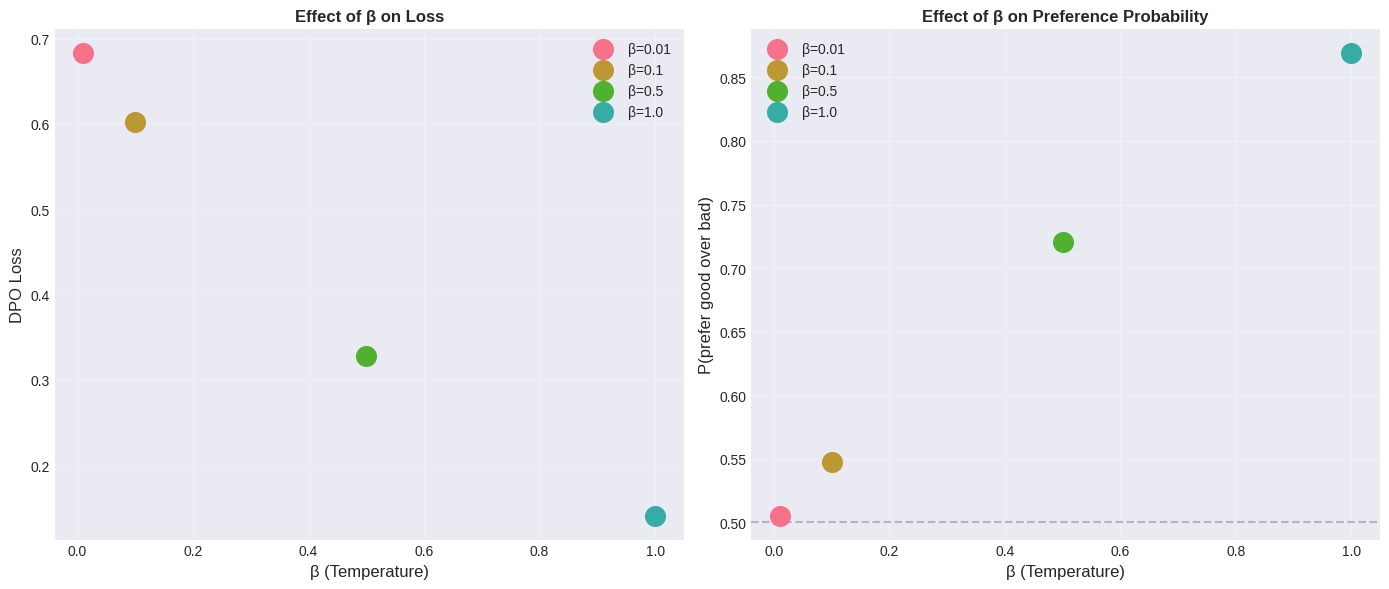


Key Takeaway:

DPO simplifies alignment by:
1. Eliminating the reward model (uses policy ratios instead)
2. Avoiding RL instability (supervised learning on preferences)
3. One-stage training (no separate RM + PPO phases)

The trade-off:
- Less exploration than PPO
- Dataset-dependent (can't discover new good behaviors)
- Implicit KL constraint (vs explicit in PPO)

For most practical alignment tasks, DPO's stability wins.

Experiment complete! Modify parameters above and re-run.


In [1]:
"""
Direct Preference Optimization (DPO) - Mathematical Playground
================================================================

Understand how DPO trains language models directly from preferences,
bypassing the complexity of RLHF and PPO.

Run each cell to explore:
1. RLHF vs DPO comparison
2. Bradley-Terry preference model
3. DPO loss function mechanics
4. Training dynamics visualization
5. Policy optimization trajectories
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from scipy.stats import norm
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# ============================================================================
# PART 1: Bradley-Terry Preference Model
# ============================================================================

print("="*70)
print("PART 1: Bradley-Terry Model - The Foundation")
print("="*70)

def bradley_terry_probability(reward_a, reward_b):
    """
    Compute probability that option A is preferred over B.

    P(A > B) = σ(r_A - r_B) = 1 / (1 + exp(-(r_A - r_B)))

    Args:
        reward_a: Reward/score for option A
        reward_b: Reward/score for option B

    Returns:
        Probability that A is preferred
    """
    return sigmoid(reward_a - reward_b)

# Example: Two responses with different rewards
reward_good = 5.0  # High-quality response
reward_bad = 2.0   # Low-quality response

prob_prefer_good = bradley_terry_probability(reward_good, reward_bad)
prob_prefer_bad = bradley_terry_probability(reward_bad, reward_good)

print(f"\nResponse A reward: {reward_good}")
print(f"Response B reward: {reward_bad}")
print(f"\nP(A > B) = {prob_prefer_good:.3f}")
print(f"P(B > A) = {prob_prefer_bad:.3f}")
print(f"Sum = {prob_prefer_good + prob_prefer_bad:.3f}")

# Visualize the Bradley-Terry curve
reward_diff = np.linspace(-5, 5, 100)
prob = sigmoid(reward_diff)

plt.figure(figsize=(10, 6))
plt.plot(reward_diff, prob, 'b-', linewidth=2.5, label='P(A > B)')
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Indifference')
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
plt.scatter([reward_good - reward_bad], [prob_prefer_good],
           c='green', s=200, zorder=5, edgecolors='darkgreen', linewidth=2,
           label=f'Our example (Δr={reward_good-reward_bad})')
plt.xlabel('Reward Difference (r_A - r_B)', fontsize=12)
plt.ylabel('P(A > B)', fontsize=12)
plt.title('Bradley-Terry Model: How Reward Difference → Preference Probability',
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('dpo_bradley_terry.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualization saved: dpo_bradley_terry.png")
plt.show()

# ============================================================================
# PART 2: From Rewards to Policy Ratios (The DPO Insight)
# ============================================================================

print("\n" + "="*70)
print("PART 2: The Key Transformation - Reward to Policy Ratio")
print("="*70)

def reward_from_policy_ratio(policy_prob, ref_policy_prob, beta=0.1):
    """
    Compute implicit reward from policy likelihood ratio.

    r(x, y) = β * log(π(y|x) / π_ref(y|x))

    This is the DPO insight: no explicit reward model needed!

    Args:
        policy_prob: Current policy probability π(y|x)
        ref_policy_prob: Reference policy probability π_ref(y|x)
        beta: Temperature parameter

    Returns:
        Implicit reward
    """
    return beta * np.log(policy_prob / ref_policy_prob)

# Example: Two responses
pi_ref_good = 0.01  # Reference model gives 1% to good response
pi_ref_bad = 0.05   # Reference model gives 5% to bad response (common but bad)

pi_theta_good = 0.04  # Our policy gives 4% to good response (improving!)
pi_theta_bad = 0.03   # Our policy gives 3% to bad response (decreasing!)

beta = 0.1

r_good = reward_from_policy_ratio(pi_theta_good, pi_ref_good, beta)
r_bad = reward_from_policy_ratio(pi_theta_bad, pi_ref_bad, beta)

print(f"\nReference model probabilities:")
print(f"  π_ref(good response) = {pi_ref_good}")
print(f"  π_ref(bad response) = {pi_ref_bad}")

print(f"\nCurrent policy probabilities:")
print(f"  π_θ(good response) = {pi_theta_good}")
print(f"  π_θ(bad response) = {pi_theta_bad}")

print(f"\nImplicit rewards (β={beta}):")
print(f"  r(good) = {r_good:.3f}")
print(f"  r(bad) = {r_bad:.3f}")
print(f"  Δr = {r_good - r_bad:.3f}")

print(f"\nP(prefer good over bad) = {bradley_terry_probability(r_good, r_bad):.3f}")

# ============================================================================
# PART 3: DPO Loss Function
# ============================================================================

print("\n" + "="*70)
print("PART 3: DPO Loss Function Mechanics")
print("="*70)

def dpo_loss(pi_theta_w, pi_theta_l, pi_ref_w, pi_ref_l, beta=0.1):
    """
    Compute DPO loss for a single preference pair.

    L_DPO = -log σ(β log(π_θ(y_w|x)/π_ref(y_w|x)) - β log(π_θ(y_l|x)/π_ref(y_l|x)))

    Args:
        pi_theta_w: Policy probability for preferred response (winner)
        pi_theta_l: Policy probability for dispreferred response (loser)
        pi_ref_w: Reference probability for winner
        pi_ref_l: Reference probability for loser
        beta: Temperature parameter

    Returns:
        DPO loss value
    """
    # Compute log likelihood ratios
    log_ratio_w = np.log(pi_theta_w / pi_ref_w)
    log_ratio_l = np.log(pi_theta_l / pi_ref_l)

    # DPO objective
    logit = beta * (log_ratio_w - log_ratio_l)

    # Negative log probability
    loss = -np.log(sigmoid(logit))

    return loss, logit

# Compute loss for our example
loss, logit = dpo_loss(pi_theta_good, pi_theta_bad, pi_ref_good, pi_ref_bad, beta)

print(f"\nDPO Loss Breakdown:")
print(f"  log(π_θ(good) / π_ref(good)) = {np.log(pi_theta_good/pi_ref_good):.3f}")
print(f"  log(π_θ(bad) / π_ref(bad)) = {np.log(pi_theta_bad/pi_ref_bad):.3f}")
print(f"  β * (ratio_good - ratio_bad) = {logit:.3f}")
print(f"  σ(logit) = {sigmoid(logit):.3f}")
print(f"  Loss = -log(σ(logit)) = {loss:.3f}")

print(f"\nInterpretation:")
if logit > 0:
    print(f"  ✓ Policy prefers good over bad (logit > 0)")
    print(f"  → Loss is low ({loss:.3f}), gradient will be small")
else:
    print(f"  ✗ Policy prefers bad over good (logit < 0)")
    print(f"  → Loss is high, gradient will push policy toward good")

# ============================================================================
# PART 4: Training Dynamics Visualization
# ============================================================================

print("\n" + "="*70)
print("PART 4: Simulating DPO Training Dynamics")
print("="*70)

def simulate_dpo_training(n_steps=100, learning_rate=0.05, beta=0.1):
    """
    Simulate DPO training on a toy problem.

    Scenario: Policy learns to prefer good responses over bad ones.
    """
    # Initial policy (close to reference)
    pi_theta_good = 0.01
    pi_theta_bad = 0.05

    # Reference policy (frozen)
    pi_ref_good = 0.01
    pi_ref_bad = 0.05

    # Track history
    history = {
        'step': [],
        'pi_good': [],
        'pi_bad': [],
        'loss': [],
        'preference_prob': []
    }

    for step in range(n_steps):
        # Compute loss and gradients
        loss, logit = dpo_loss(pi_theta_good, pi_theta_bad,
                               pi_ref_good, pi_ref_bad, beta)

        # Approximate gradient (simplified for illustration)
        # Real implementation uses autograd
        grad_good = -sigmoid(-logit) * beta / pi_theta_good
        grad_bad = sigmoid(-logit) * beta / pi_theta_bad

        # Gradient descent
        pi_theta_good -= learning_rate * grad_good
        pi_theta_bad -= learning_rate * grad_bad

        # Clip to valid probabilities
        pi_theta_good = np.clip(pi_theta_good, 0.001, 0.99)
        pi_theta_bad = np.clip(pi_theta_bad, 0.001, 0.99)

        # Compute preference probability
        r_good = reward_from_policy_ratio(pi_theta_good, pi_ref_good, beta)
        r_bad = reward_from_policy_ratio(pi_theta_bad, pi_ref_bad, beta)
        pref_prob = bradley_terry_probability(r_good, r_bad)

        # Record
        history['step'].append(step)
        history['pi_good'].append(pi_theta_good)
        history['pi_bad'].append(pi_theta_bad)
        history['loss'].append(loss)
        history['preference_prob'].append(pref_prob)

    return history

# Run simulation
history = simulate_dpo_training(n_steps=100, learning_rate=0.05, beta=0.1)

print(f"\nTraining Summary:")
print(f"  Initial P(prefer good) = {history['preference_prob'][0]:.3f}")
print(f"  Final P(prefer good) = {history['preference_prob'][-1]:.3f}")
print(f"  Initial π_θ(good) = {history['pi_good'][0]:.4f}")
print(f"  Final π_θ(good) = {history['pi_good'][-1]:.4f}")
print(f"  Initial π_θ(bad) = {history['pi_bad'][0]:.4f}")
print(f"  Final π_θ(bad) = {history['pi_bad'][-1]:.4f}")

# Visualize training dynamics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Policy probabilities
axes[0, 0].plot(history['step'], history['pi_good'], 'g-', linewidth=2, label='π_θ(good response)')
axes[0, 0].plot(history['step'], history['pi_bad'], 'r-', linewidth=2, label='π_θ(bad response)')
axes[0, 0].set_xlabel('Training Step')
axes[0, 0].set_ylabel('Policy Probability')
axes[0, 0].set_title('Policy Evolution During DPO Training', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Loss curve
axes[0, 1].plot(history['step'], history['loss'], 'b-', linewidth=2)
axes[0, 1].set_xlabel('Training Step')
axes[0, 1].set_ylabel('DPO Loss')
axes[0, 1].set_title('Loss Decreases as Policy Learns Preferences', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Preference probability
axes[1, 0].plot(history['step'], history['preference_prob'], 'purple', linewidth=2)
axes[1, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random (50%)')
axes[1, 0].set_xlabel('Training Step')
axes[1, 0].set_ylabel('P(prefer good over bad)')
axes[1, 0].set_title('Policy Increasingly Prefers Good Response', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Probability ratio
ratio_good = np.array(history['pi_good']) / 0.01  # Divide by pi_ref_good
ratio_bad = np.array(history['pi_bad']) / 0.05    # Divide by pi_ref_bad

axes[1, 1].plot(history['step'], ratio_good, 'g-', linewidth=2, label='π_θ(good) / π_ref(good)')
axes[1, 1].plot(history['step'], ratio_bad, 'r-', linewidth=2, label='π_θ(bad) / π_ref(bad)')
axes[1, 1].axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Same as reference')
axes[1, 1].set_xlabel('Training Step')
axes[1, 1].set_ylabel('Likelihood Ratio')
axes[1, 1].set_title('Policy Diverges from Reference (Good↑, Bad↓)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('dpo_training_dynamics.png', dpi=150, bbox_inches='tight')
print("\n✓ Visualization saved: dpo_training_dynamics.png")
plt.show()

# ============================================================================
# PART 5: Comparing RLHF vs DPO
# ============================================================================

print("\n" + "="*70)
print("PART 5: RLHF vs DPO Complexity Comparison")
print("="*70)

# Complexity comparison
comparison = {
    'Aspect': [
        'Number of Models',
        'Training Stages',
        'Loss Function',
        'Stability',
        'Hyperparameters',
        'Computational Cost',
        'Distribution Shift',
        'Exploration'
    ],
    'RLHF (PPO)': [
        '3 (Policy, Value, Reward)',
        '2 (RM training + RL)',
        'Complex (PPO objective)',
        'Unstable (mode collapse)',
        'Many (LR×3, clip, KL, ...)',
        'High (sampling + scoring)',
        'Problematic (RM vs Policy)',
        'Yes (via sampling)'
    ],
    'DPO': [
        '1 (Policy only)',
        '1 (Direct optimization)',
        'Simple (log-likelihood)',
        'Stable (supervised learning)',
        'Few (LR, β)',
        'Low (standard gradient)',
        'Implicitly handled',
        'Limited (dataset only)'
    ]
}

print("\n┌─────────────────────────┬──────────────────────────┬─────────────────────────┐")
print("│ Aspect                  │ RLHF (PPO)               │ DPO                     │")
print("├─────────────────────────┼──────────────────────────┼─────────────────────────┤")
for i in range(len(comparison['Aspect'])):
    aspect = comparison['Aspect'][i]
    rlhf = comparison['RLHF (PPO)'][i]
    dpo = comparison['DPO'][i]
    print(f"│ {aspect:23} │ {rlhf:24} │ {dpo:23} │")
print("└─────────────────────────┴──────────────────────────┴─────────────────────────┘")

# ============================================================================
# PART 6: Interactive Exploration
# ============================================================================

print("\n" + "="*70)
print("PART 6: Experiment with Different Parameters")
print("="*70)

def explore_beta_effect(beta_values=[0.01, 0.1, 0.5, 1.0]):
    """
    Explore how β (temperature) affects DPO behavior.

    β controls the strength of KL constraint from reference policy.
    """
    pi_theta_good = 0.04
    pi_theta_bad = 0.03
    pi_ref_good = 0.01
    pi_ref_bad = 0.05

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for beta in beta_values:
        loss, logit = dpo_loss(pi_theta_good, pi_theta_bad,
                               pi_ref_good, pi_ref_bad, beta)

        r_good = reward_from_policy_ratio(pi_theta_good, pi_ref_good, beta)
        r_bad = reward_from_policy_ratio(pi_theta_bad, pi_ref_bad, beta)
        pref_prob = bradley_terry_probability(r_good, r_bad)

        ax1.scatter(beta, loss, s=200, label=f'β={beta}', zorder=5)
        ax2.scatter(beta, pref_prob, s=200, label=f'β={beta}', zorder=5)

    ax1.set_xlabel('β (Temperature)', fontsize=12)
    ax1.set_ylabel('DPO Loss', fontsize=12)
    ax1.set_title('Effect of β on Loss', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.set_xlabel('β (Temperature)', fontsize=12)
    ax2.set_ylabel('P(prefer good over bad)', fontsize=12)
    ax2.set_title('Effect of β on Preference Probability', fontweight='bold')
    ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('dpo_beta_exploration.png', dpi=150, bbox_inches='tight')
    print("\n✓ Visualization saved: dpo_beta_exploration.png")
    plt.show()

explore_beta_effect()

print("\n" + "="*70)
print("Key Takeaway:")
print("="*70)
print("""
DPO simplifies alignment by:
1. Eliminating the reward model (uses policy ratios instead)
2. Avoiding RL instability (supervised learning on preferences)
3. One-stage training (no separate RM + PPO phases)

The trade-off:
- Less exploration than PPO
- Dataset-dependent (can't discover new good behaviors)
- Implicit KL constraint (vs explicit in PPO)

For most practical alignment tasks, DPO's stability wins.
""")

print("="*70)
print("Experiment complete! Modify parameters above and re-run.")
print("="*70)